# Linear Models

## Load data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [6]:
path1 = Path("Data/batch1.pkl")
batch1 = pickle.load(open(path1, 'rb'))

#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [7]:
path2 = Path("Data/batch2.pkl")
batch2 = pickle.load(open(path2, 'rb'))

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [8]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [9]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [10]:
path3 = Path("Data/batch3.pkl")
batch3 = pickle.load(open(path3, 'rb'))

# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

In [11]:
bat_dict = {**batch1, **batch2, **batch3}

In [12]:
numBat1 = len(batch1.keys())
numBat2 = len(batch2.keys())
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3


test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

## Linear Models

In [86]:
import pandas as pd
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [150]:
# create dataframe with Delta Qdlin and cycles as features
variances = np.array([])
cycle_life = np.array([])
for cell in bat_dict.values():
    c10 = cell['cycles']['10']
    c100 = cell['cycles']['100']
    dQ_100_10 = c100['Qdlin'] - c10['Qdlin']
    variances = np.append(variances, np.log(np.var(dQ_100_10)))
    cycle_life = np.append(cycle_life, cell["cycle_life"])

df = pd.DataFrame({"Delta_Qd_100_10_log_variance": variances, 
                   "cycles": cycle_life})

In [151]:
df.head()

,Delta_Qd_100_10_log_variance,cycles
0,-11.631570,1852.0
1,-11.825562,2160.0
2,-11.402131,2237.0
3,-10.099939,1434.0
4,-10.602896,1709.0


In [152]:
varmod_features = ["Delta_Qd_100_10_log_variance"]
dismod_features = ["..."]
fullmod_features = ["..."]

# Variance Model

In [ ]:
# ========================================

In [192]:
def get_split(data, features, split):
    X = data.iloc[split,:].loc[:,features]
    y = data.iloc[split,-1:]
    return X, y

def eval_model(model, data, splits, features):
    rmse = list()
    mpe = list()
    for split in splits:
        X, y = get_split(data, features, split)
        pred = model.predict(X)
        rmse.append(np.sqrt(mean_squared_error(pred, y)))
        mpe.append(float(np.mean(np.abs((y - pred.reshape(-1,1))) / y * 100)))
    return rmse, mpe

In [189]:
# Train the model
x_train, y_train = get_split(df, varmod_features, train_ind)

alphas = np.linspace(0.0001,1,30)
parameters = {
    "alpha": alphas,
    "l1_ratio": [0.01, 0.25, 0.5, 0.75, 1.]
}
enet = ElasticNet(random_state=54)
regr = GridSearchCV(enet, parameters, cv=4, iid=False)
regr.fit(x_train, y_train).score(x_train, y_train)

In [195]:
# get RMSE and MPE to compare with paper results
splits = [train_ind, test_ind, secondary_test_ind]
varmod_rmse, varmod_mpe = eval_model(regr, df, splits, varmod_features)

In [ ]:
# ==========================================

In [154]:
# Define train and two test sets for Variance model
x_train = df.iloc[train_ind,:].loc[:,varmod_features]
y_train = df.iloc[train_ind,-1:]
x_test = df.iloc[test_ind,;].loc[:,varmod_features]
y_test = df.iloc[test_ind,-1:]
x_test_sec = df.iloc[secondary_test_ind,:].loc[:,varmod_features]
y_test_sec = df.iloc[secondary_test_ind,-1:]

In [155]:
# train elastic net on variance model
alphas = np.linspace(0.0001,1,30)
parameters = {
    "alpha": alphas,
    "l1_ratio": [0.01, 0.25, 0.5, 0.75, 1.]
}
enet = ElasticNet(random_state=54)
regr = GridSearchCV(enet, parameters, cv=4, iid=False)
regr.fit(x_train, y_train).score(x_train, y_train)

0.7787713570570229

In [156]:
# because elastic net does not work well with a small alpha,
# we also train a linear regression to see if it performs better
# > it actually does, so we use lin_reg for the "Variance model"
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train).score(x_train, y_train)

0.779697297534494

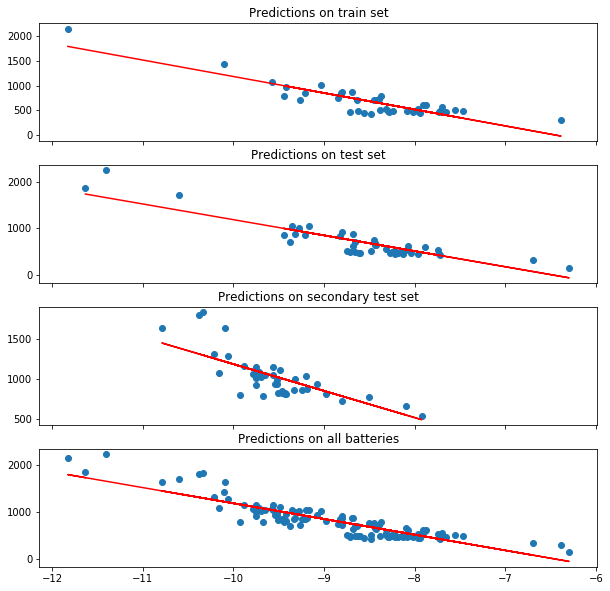

In [158]:
fig, ax = plt.subplots(4, sharex=True, figsize=(10,10))
pred_train = lin_reg.predict(x_train)
ax[0].scatter(x_train, y_train)
ax[0].plot(x_train, pred_train, color="red")
ax[0].set_title("Predictions on train set")
pred_test = lin_reg.predict(x_test)
ax[1].scatter(x_test, y_test)
ax[1].plot(x_test, pred_test, color="red")
ax[1].set_title("Predictions on test set")
pred_test_sec = lin_reg.predict(x_test_sec)
ax[2].scatter(x_test_sec, y_test_sec)
ax[2].plot(x_test_sec, pred_test_sec, color="red")
ax[2].set_title("Predictions on secondary test set")
pred_all = lin_reg.predict(df.loc[:,varmod_features])
ax[3].scatter(df.loc[:,varmod_features], df.iloc[:,-1])
ax[3].plot(df.loc[:,varmod_features], pred_all, color="red")
ax[3].set_title("Predictions on all batteries")
plt.show()

In [42]:
# Get metrics for Variance model
varmod_rmse_train = np.sqrt(mean_squared_error(
                lin_reg.predict(x_train), y_train))
varmod_rmse_test = np.sqrt(mean_squared_error(
                lin_reg.predict(x_test), y_test))
varmod_rmse_test_sec = np.sqrt(mean_squared_error(
                lin_reg.predict(x_test_sec), y_test_sec))

# MPE definition: https://help.sap.com/doc/saphelp_scm700_ehp02/7.0.2/en-US/0b/a2ca53f1a1214be10000000a174cb4/content.htm?no_cache=true
varmod_mpe_train = float(np.mean(np.abs((y_train - lin_reg.predict(x_train)
                                   .reshape(-1,1))) / y_train * 100))
varmod_mpe_test = float(np.mean(np.abs((y_test - lin_reg.predict(x_test)
                                   .reshape(-1,1))) / y_test * 100))
varmod_mpe_test_sec = float(np.mean(np.abs((y_test_sec - lin_reg.predict(x_test_sec)
                                   .reshape(-1,1))) / y_test_sec * 100))

In [ ]:
# Define train and two test sets for Discharge model
x_train = df.iloc[train_ind,:].loc[:,dismod_features]
y_train = df.iloc[train_ind,-1:]
x_test = df.iloc[test_ind,;].loc[:,dismod_features]
y_test = df.iloc[test_ind,-1:]
x_test_sec = df.iloc[secondary_test_ind,:].loc[:,dismod_features]
y_test_sec = df.iloc[secondary_test_ind,-1:]

In [ ]:
# Get metrics for Discharge Model
dismod_rmse_train = np.sqrt(mean_squared_error(
                regr.predict(x_train), y_train))
dismod_rmse_test = np.sqrt(mean_squared_error(
                regr.predict(x_test), y_test))
dismod_rmse_test_sec = np.sqrt(mean_squared_error(
                regr.predict(x_test_sec), y_test_sec))

# MPE definition: https://help.sap.com/doc/saphelp_scm700_ehp02/7.0.2/en-US/0b/a2ca53f1a1214be10000000a174cb4/content.htm?no_cache=true
dismod_mpe_train = float(np.mean(np.abs((y_train - regr.predict(x_train)
                                   .reshape(-1,1))) / y_train * 100))
dismod_mpe_test = float(np.mean(np.abs((y_test - regr.predict(x_test)
                                   .reshape(-1,1))) / y_test * 100))
dismod_mpe_test_sec = float(np.mean(np.abs((y_test_sec - regr.predict(x_test_sec)
                                   .reshape(-1,1))) / y_test_sec * 100))

In [196]:
df_metrics = pd.DataFrame({"Model":["Variance model", "Discharge model", "Full model"],
              "RMSE - Train": [varmod_rmse[0],0,0],
              "RMSE - Primary test": [varmod_rmse[1],0,0],
              "RMSE - Secondary test": [varmod_rmse[2],0,0],
              "MPE - Train": [varmod_mpe[0],0,0],
              "MPE - Primary test": [varmod_mpe[1],0,0],
              "MPE - Secondary test": [varmod_mpe[2],0,0]})
                                       
                                       
df_metrics

,Model,RMSE - Train,RMSE - Primary test,RMSE - Secondary test,MPE - Train,MPE - Primary test,MPE - Secondary test
0,Variance model,151.983723,169.488406,184.342835,21.219173,21.783186,12.548031
1,Discharge model,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Full model,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Classification Model

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [116]:
# regularized logistic regression
# Take the delta between cycles #5 and #4

cycle_threshold = 550
variances = np.array([])
cycle_life = np.array([])
cycles = np.array([])
for cell in bat_dict.values():
    c5 = cell['cycles']['5']
    c4 = cell['cycles']['4']
    dQ_5_4 = c5['Qdlin'] - c4['Qdlin']
    variances = np.append(variances, np.log(np.var(dQ_5_4)))
    cycles = np.append(cycles, cell["cycle_life"])
    cycle_life = np.append(cycle_life, cell["cycle_life"]>=cycle_threshold)

df = pd.DataFrame({
            "Delta_Qd_5_4_log_variance": variances, 
            "cycles": cycles,
            "cycle_life": cycle_life
})

In [117]:
# Define train and two test sets according to paper
x_train = df.iloc[train_ind,:-2]
y_train = df.iloc[train_ind,-1:]
x_test = df.iloc[test_ind,:-2]
y_test = df.iloc[test_ind,-1:]
x_test_sec = df.iloc[secondary_test_ind,:-2]
y_test_sec = df.iloc[secondary_test_ind,-1:]

In [118]:
df.head()

,Delta_Qd_5_4_log_variance,cycles,cycle_life
0,-14.096575,1852.0,1.0
1,-13.571824,2160.0,1.0
2,-13.341959,2237.0,1.0
3,-13.236720,1434.0,1.0
4,-14.212549,1709.0,1.0


In [130]:
# train "variance classifier"
parameters = {"C": [0.01,0.1,0.5,0.75,1]}
logreg = LogisticRegression(solver="liblinear", random_state=54)
clf = GridSearchCV(logreg, parameters, cv=4, iid=False)
clf.fit(x_train, y_train.values.ravel()).score(x_train, y_train.values.ravel())

0.8048780487804879

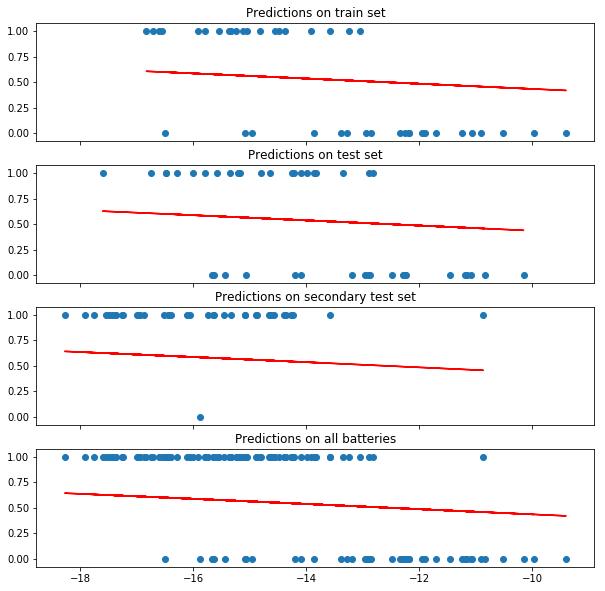

In [143]:
fig, ax = plt.subplots(4, sharex=True, figsize=(10,10))
pred_train = clf.predict_proba(x_train)[:,1]
ax[0].scatter(x_train, y_train)
ax[0].plot(x_train, pred_train, color="red")
ax[0].set_title("Predictions on train set")

pred_test = clf.predict_proba(x_test)[:,1]
ax[1].scatter(x_test, y_test)
ax[1].plot(x_test, pred_test, color="red")
ax[1].set_title("Predictions on test set")

pred_test_sec = clf.predict_proba(x_test_sec)[:,1]
ax[2].scatter(x_test_sec, y_test_sec)
ax[2].plot(x_test_sec, pred_test_sec, color="red")
ax[2].set_title("Predictions on secondary test set")

pred_all = clf.predict_proba(df["Delta_Qd_5_4_log_variance"][:,np.newaxis])[:,1]
ax[3].scatter(df["Delta_Qd_5_4_log_variance"], df["cycle_life"])
ax[3].plot(df["Delta_Qd_5_4_log_variance"], pred_all, color="red")
ax[3].set_title("Predictions on all batteries")
plt.show()

In [55]:
varclf_acc_train = accuracy_score(clf.predict(x_train), y_train.values.ravel())
varclf_acc_test = accuracy_score(clf.predict(x_test), y_test.values.ravel())
varclf_acc_test_sec = accuracy_score(clf.predict(x_test_sec), y_test_sec.values.ravel())

In [56]:
df_metrics = pd.DataFrame({"Classifier":["Variance classifier", "Full classifier"],
              "Acc - Train": [varclf_acc_train,0],
              "Acc - Primary test": [varclf_acc_test,0],
              "Acc - Secondary test": [varclf_acc_test_sec,0]})                                  
df_metrics

,Classifier,Acc - Train,Acc - Primary test,Acc - Secondary test
0,Variance classifier,0.804878,0.767442,0.95
1,Full classifier,0.000000,0.000000,0.00
